# Read dataset and create data loaders

In [1]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [19]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
'''
# Initialise vectors and batch size
transform= transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
batch_size=4
print('Batch size:', batch_size)
# Load training and testing dataset
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Batch size: 4
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1= nn.Conv2d(3,6,5)
#     self.pool= nn.MaxPool2d(2,2)
#     self.conv2= nn.Conv2d(6,16,5)
#     self.fc1= nn.Linear(16 * 5 * 5, 120)
#     self.fc2=nn.Linear(120,84)
#     self.fc3=nn.Linear(84,10)

#   def forward(self,x):
#     x= self.pool(F.relu(self.conv1(x)))
#     x= self.pool(F.relu(self.conv2(x)))
#     x= torch.flatten(x,1)
#     x= F.relu(self.fc1(x))
#     x= F.relu(self.fc2(x))
#     x= self.fc3(x)
#     return x

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self) -> None:
     super(Stem,self).__init__()
     self.stem = nn.Sequential(
       nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(64), 
       nn.ReLU(inplace=True),
       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(64),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(128),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    # print("Stem output shape in forward pass:", x.shape)
    return x

## Block

In [4]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k=4, r=4):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

In [5]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k=4, r=4, kernel_size=3, stride=1, padding=1):
    super(Block, self).__init__()
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)
    # Input from first block
    # Input from previous block for rest
    # Generate vector a with K elements from X as a= E(X)
    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

  def forward(self,x):
    a = self.expertBranch(x)
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)
    a= a.view(a.size(0), self.k, 1,1,1)

    out = (a* stacked).sum(dim=1)

    return out

## Backbone

In [6]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels=64, hidden_channels=64, num_blocks=3, k=4, r=4):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
      x = block(x)
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
    return x

## Classifier

In [7]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes=10, use_mlp=False):
    super(Classifier,self).__init__()
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(0.3), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    # print("Classifier input shape:", x.shape)
    out = self.classifier(x)
    # print("Classifier output shape (logits):", out.shape)
    return out


# Model

In [8]:
class Model(nn.Module):
  def __init__(self, stem_channels= 128, hidden_channels=128, num_blocks=3, k=4, r=4, num_classes=10, use_mlp=False):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem()
    # Call backbone
    self.backbone= Backbone(input_channels=stem_channels, hidden_channels= hidden_channels, num_blocks=num_blocks, k=k, r=r)
    # Call classifier
    self.classifier= Classifier(input_channels=hidden_channels, num_classes=num_classes, use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [9]:
model = Model(
    stem_channels=128,
    hidden_channels=128,
    num_blocks=3,
    k=4,
    r=4,
    num_classes=10,
    use_mlp=True
)


criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training & Testing

In [20]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# ---------- Log training ----------
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# ---------- Training + Validation Loops ----------
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# ---------- 5. Main Loop ----------
epochs = 25
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")

print("\nTraining Complete")

# ---------- 8. Print Final Averages ----------
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# ---------- 7. Plot Results ----------

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")



Epoch 1/25


Train Loss: 2.3046 | Accuracy: 9.77%
Val   Loss: 2.3026 | Accuracy: 10.00%
Saved best model.

Epoch 2/25


KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified
GPU training enabled
--------------------------------------------------
Starting training...
Epoch 1:
  Train loss: 1.768
  Train accuracy: 0.314 (31.4%)
  Test accuracy:  0.375 (37.5%)
Epoch 2:
  Train loss: 1.487
  Train accuracy: 0.442 (44.2%)
  Test accuracy:  0.427 (42.7%)
Epoch 3:
  Train loss: 1.341
  Train accuracy: 0.508 (50.8%)
  Test accuracy:  0.534 (53.4%)
Epoch 4:
  Train loss: 1.233
  Train accuracy: 0.557 (55.7%)
  Test accuracy:  0.590 (59.0%)
Epoch 5:
  Train loss: 1.164
  Train accuracy: 0.586 (58.6%)
  Test accuracy:  0.610 (61.0%)
Epoch 6:
  Train loss: 1.115
  Train accuracy: 0.605 (60.5%)
  Test accuracy:  0.639 (63.9%)
Epoch 7:
  Train loss: 1.070
  Train accuracy: 0.623 (62.3%)
  Test accuracy:  0.526 (52.6%)
Epoch 8:
  Train loss: 1.022
  Train accuracy: 0.643 (64.3%)
  Test accuracy:  0.622 (62.2%)
Epoch 9:
  Train loss: 0.995
  Train accuracy: 0.652 (65.2%)
  Test accuracy:  0.567 (5

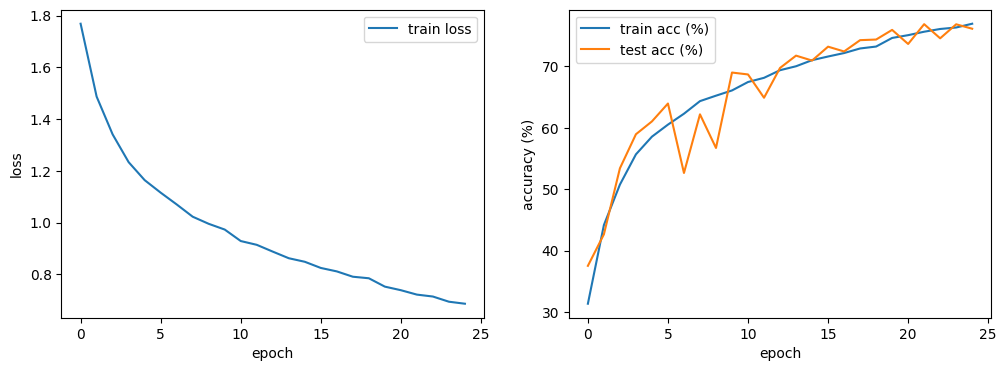

Model saved as best_model.pth

Final Metrics:
Final train loss: 0.6863
Final train accuracy: 76.93%
Final test accuracy: 76.12%


In [ ]:
# ### Data loading and augmentation from test_train.py ###
# # Added Normalize with the standard CIFAR-10 statistics
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
# ])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
# ])

# # Downloading and creating the Datasets here
# train_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform_train
# )
# test_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test
# )

# # Creating DataLoaders here
# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# ### Training utilities from test_train.py (with fixed method names) ###
# class Accumulator:
#     """For accumulating sums over n variables."""
#     def __init__(self, n):
#         self.data = [0.0] * n
#     def add(self, *args):
#         self.data = [a + float(b) for a, b in zip(self.data, args)]
#     def reset(self):
#         self.data = [0.0] * len(self.data)
#     def __getitem__(self, idx):
#         return self.data[idx]

# def accuracy(y_hat, y):
#     """Compute the number of correct predictions."""
#     if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
#         y_hat = y_hat.argmax(axis=1)
#     cmp = (y_hat.type(y.dtype) == y)
#     return float(torch.sum(cmp))

# def evaluate_accuracy(net, data_iter, device): 
#     """Compute the accuracy for a model on a dataset."""
#     net.eval()
#     metric = Accumulator(2)  # No. of correct predictions, no. of predictions
#     with torch.no_grad():
#         for X, y in data_iter:
#             X, y = X.to(device), y.to(device)
#             metric.add(accuracy(net(X), y), y.numel())
#     return metric[0] / metric[1]

# def train_epoch(net, train_iter, loss, optimizer, device):
#     """Training function for one epoch."""
#     net.train()
#     metric = Accumulator(3)  # train_loss, train_acc, num_examples
#     for X, y in train_iter:
#         X, y = X.to(device), y.to(device)
#         optimizer.zero_grad()
#         y_hat = net(X)
#         l = loss(y_hat, y)
#         l.backward()
#         optimizer.step()
#         metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
#     return metric[0] / metric[2], metric[1] / metric[2]

# def train_model(net, train_iter, test_iter, loss, optimizer, num_epochs, device):
#     """Train and evaluate a model."""
#     print('-' * 50)
#     print('Starting training...')
    
#     train_losses = []
#     train_accs = []
#     test_accs = []
    
#     for epoch in range(num_epochs):
#         train_metrics = train_epoch(net, train_iter, loss, optimizer, device)
#         test_acc = evaluate_accuracy(net, test_iter, device)
#         train_loss, train_acc = train_metrics
        
#         train_losses.append(train_loss)
#         train_accs.append(train_acc)
#         test_accs.append(test_acc)
        
#         print(f'Epoch {epoch + 1}:')
#         print(f'  Train loss: {train_loss:.3f}')
#         print(f'  Train accuracy: {train_acc:.3f} ({train_acc*100:.1f}%)')
#         print(f'  Test accuracy:  {test_acc:.3f} ({test_acc*100:.1f}%)')
    
#     # Plot metrics
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='train loss')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot([x*100 for x in train_accs], label='train acc (%)')
#     plt.plot([x*100 for x in test_accs], label='test acc (%)')
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy (%)')
#     plt.legend()
#     plt.savefig('training_results.png')
#     plt.show()
    
#     return train_losses, train_accs, test_accs

# ### Main execution block ###
# if __name__ == '__main__':
#     # Device configuration
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     if device.type == 'cuda':
#         print('GPU training enabled')  # Simplified device info
    
#     # Create your model from mymodel.py
#     model = Model(
#         stem_channels=128,
#         hidden_channels=128,
#         num_blocks=3,
#         k=4,
#         r=4,
#         num_classes=10,
#         use_mlp=True
#     ).to(device)
    
#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     # Train the model
#     train_losses, train_accs, test_accs = train_model(
#         model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device=device
#     )
    
#     # Save model
#     torch.save(model.state_dict(), "best_model.pth")
#     print("Model saved as best_model.pth")
    
#     # Print final metrics
#     print("\nFinal Metrics:")
#     print(f"Final train loss: {train_losses[-1]:.4f}")
#     print(f"Final train accuracy: {train_accs[-1]*100:.2f}%")
#     print(f"Final test accuracy: {test_accs[-1]*100:.2f}%")

Averages:


*   Train Loss: 1.7223, Accuracy: 38.21%, Validation Loss: 1.7194, Accuracy: 38.25%
*   Train Loss: 1.7106, Accuracy: 34.80%, Validation Loss: 1.7984, Accuracy: 35.98%

*   Train Loss: 1.8150, Accuracy: 34.54%, Val   Loss: 1.7848 Accuracy: 36.13%

*   Train Loss: 1.9579, Accuracy: 28.84%, Val   Loss: 1.8691, Accuracy: 32.51%
*   Train Loss: 1.9712, Accuracy: 27.54%, Val   Loss: 1.9107 ,Accuracy: 30.24%
*   Train Loss: 2.1609, Accuracy: 16.97%, Val   Loss: 2.1343, Accuracy: 18.28%
*   Train Loss: 1.9798, Accuracy: 27.24%, Val   Loss: 1.9312, Accuracy: 29.65%
*   Train Loss: 1.4970, Accuracy: 44.11%, Val   Loss: 1.3675, Accuracy: 48.65%
*   Train Loss: 1.3648, Accuracy: 51.66%, Val   Loss: 1.2319, Val   Accuracy: 55.56%
